In [1]:
# Numerical/Stats pack
import numpy as np
from collections import Counter
import math
import numpy.linalg as nl
from cvxopt import matrix, solvers

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from qiskit.visualization import plot_histogram
plt.rcParams["figure.dpi"] = 150

In [2]:
def get_basis(num_qubits, index):
    """
    Parameters
    ----------
    num_qubits : int
        number of qubits.
    index : int
        Which qubit is 1. Order follows measurement order

    Returns
    -------
    base : int
        the basis string where target position is 1
        e.g., num_qubits=5, index=1, then return '01000'

    """
    origin = list('0'*num_qubits)
    origin[index] = '1'
    return ''.join(origin)
    
def qubit_matrix(p0m0,p1m1):
    """
    Parameters
    ----------
    p0m0 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(0|0) for all qubits
    p1m1 : ndarray(dtype=np.float64, dim=num_qubits)
        Pr(1|1) for all qubits

    Returns
    -------
    mats: np.array(dim=num_qubits*2*2)
        mats[i] is 2-by-2 measurement error transition matrix for ith qubit
    """
    num_qubits = p0m0.shape[0]
    mats = np.zeros((num_qubits,2,2), dtype=np.float64)
    for i in range(num_qubits):
        mats[i] = np.array([[p0m0[i], 1-p1m1[i]],[1-p0m0[i], p1m1[i]]])
        
    return mats

def dictToVec(nQubits, counts):
    """ Transfer counts to probabilities

    Args:
      nQUbits: int
        number of qubits
      counts: dict
        an dictionary in the form {basis string: frequency}. E.g.
        {"01": 100
         "11": 100}
        dict key follow little-endian convention

    Returns: numpy array
      an probability vector (array). E.g.
      [0, 0.5, 0, 0.5] is the result from example above.
    """
    vec = np.zeros(2**nQubits)
    form = "{0:0" + str(nQubits) + "b}"
    for i in range(2**nQubits):
        key = form.format(i) # consider key = format(i,'0{}b'.format(nQubits))
                             # and delete variable form
        if key in counts.keys():
            vec[i] = int(counts[key])
        else:
            vec[i] = 0
    return vec


def print_info(mat):
    u, s, vh = np.linalg.svd(mean_mat-ind_mat, full_matrices=True)
    ns = np.sum(s<1e-3)
    print("Rank={:.4g} # singular value < 1e-3={:.4g}".format(np.linalg.matrix_rank(mat),ns))
    print("Inf norm={:.4g}, Frobenius norm={:.4g}, 2-Norm={:.4g}".format(np.linalg.norm(mat, ord=np.inf), 
                                                                              np.linalg.norm(mat, ord='fro'),
                                                                              np.linalg.norm(mat, ord=2)))
    print("Among {:d} entries, {:d} entries < 1e-3, {:d} entries < 1e-4, {:d} entries < 1e-6".format(mat.shape[0]*mat.shape[1],
                                                                                                      mat[np.abs(mat)<1e-3].shape[0],
                                                                                                      mat[np.abs(mat)<1e-4].shape[0], 
                                                                                                      mat[np.abs(mat)<1e-6].shape[0]))
    
    
def extract_qubits(s, pos, correct_rest_bits):
    # Extract elements in given positions
    # E.g., s = '11010', pos = [0,2,3], correct_rest_bits = '10', the func returns 0, '101'
    # E.g., s = '11011', pos = [0,2,3], correct_rest_bits = '10', the func returns 1, '101'
    # E.g., s = '10011', pos = [0,2,3], correct_rest_bits = '10', the func returns 2, '101'
    # Because one of the unselected qubits (the last one) is different from correct_rest_bits
    res = []
    cor_count = 0
    total_num_qubits = len(pos)+len(correct_rest_bits)
    correct_rest_list = list(correct_rest_bits)
    for i in range(total_num_qubits):
        if i in pos:
            res.append(s[i])
        else:
            if s[i] != correct_rest_list.pop(0):
                cor_count += 1
    return cor_count, ''.join(res)

def recover_basis(target_basis, pos, rest_bits):
    # E.g., i = 3 (corresponds to '011'), pos = [0,2,3], rest_bits = '01'
    # func returns '0(0)11(1)'(no brackets) where two bits 0 and 1 in () corresponds to qubit 1 and 4
    total_num_qubits = len(pos)+len(rest_bits)
    selected_bits = list(target_basis)
    rest_bits_list = list(rest_bits)
    res = []
    for i in range(total_num_qubits):
        if i in pos:
            res.append(selected_bits.pop(0))
        else:
            res.append(rest_bits_list.pop(0))
    return ''.join(res)

    
def read_string_data(target_basis, selected_qubits, total_qubits, file_address, file_name=''):
    #target_basis corresponds to selected_qubits, instead of all qubits
    unselected_num_qubits = total_qubits - len(selected_qubits)
    if unselected_num_qubits == 0:
        if len(file_name) > 0:
            return np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str)
        return np.genfromtxt(file_address + 'Basis'+target_basis+'.csv', delimiter=',',dtype=np.str)
    else:
        orgin_data = np.array([],dtype=np.str)
        selected_data = np.array([],dtype=np.str)
        unselected_data = np.array([],dtype=np.str)
        for bn in range(2**unselected_num_qubits):
#         for bn in range(1):
            rest_bits = format(bn, "0{:d}b".format(unselected_num_qubits)) # Only look at the case when the rest qubits are 0
            full_basis = recover_basis(target_basis, selected_qubits, rest_bits) # basis that length num_qubits 
                                                                      # where the selected indices corresponds to target_basis
            print(target_basis, '->', full_basis, end='\r')
            if len(file_name) > 0:
                orgin_data = np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str)
#                 origin_data = np.append(orgin_data, np.genfromtxt(file_address + file_name, delimiter=',',dtype=np.str))
            else:
                orgin_data = np.genfromtxt(file_address + 'Basis'+full_basis+'.csv', delimiter=',',dtype=np.str)
#                 origin_data = np.append(orgin_data, np.genfromtxt(file_address + 'Basis'+full_basis+'.csv', delimiter=',',dtype=np.str))
            # Select out all uncorrelated bits
            for s in orgin_data:
                corr_count, new_s = extract_qubits(s, selected_qubits, rest_bits)
                if corr_count == 0:
                    selected_data = np.append(selected_data, new_s)
                else:
                    unselected_data = np.append(unselected_data, new_s)
    return selected_data

In [3]:
# Cite https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/
  
# function to check if x is power of 2 
def isPowerOfTwo( x ): 
  
    # First x in the below expression is 
    # for the case when x is 0 
    return x and (not(x & (x - 1))) 
  
# function to check whether the two numbers 
# differ at one bit position only 
def differAtOneBitPos( a , b ): 
    return isPowerOfTwo(a ^ b) 
 
# Function to find the position of 
# rightmost set bit in 'n'
def getRightMostSetBit(n):
    if (n == 0):
        return 0
 
    return math.log2(n & -n)
 
# Cite https://www.geeksforgeeks.org/position-rightmost-different-bit/
# Function to find the position of 
# rightmost different bit in the 
# binary representations of 'm' and 'n'
def posOfRightMostDiffBit(m, n):
 
    # position of rightmost different
    # bit
    return int(getRightMostSetBit(m ^ n))

In [4]:
# Choose machine
# file_address = "./QuitoData2/" # Both machine has 5 qubits
file_address = "./LimaData/" # Both machine has 5 qubits
# file_address = './BelemData/'
total_qubits = 5
selected_qubits = [0,1,2,3,4] # Measurement order
num_qubits = len(selected_qubits)

In [5]:
# Full Matrix
mean_mat = np.zeros((2**num_qubits,2**num_qubits))
for bn in range(2**num_qubits):
    target = format(bn, "0{:d}b".format(num_qubits))
    string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
    mean_mat[:,int(target,2)] = dictToVec(num_qubits,dict(Counter(string_data)))/string_data.shape[0]
    
np.savetxt(file_address+"Afull.txt", mean_mat)

In [6]:
def norm_and_N(N):
    # Method 1
    ind_data0 = {} # Given 0
    ind_data1 = {} # Given 1
    for q in range(len(selected_qubits)):
        ind_data0[q] = np.array([], dtype = np.int)
        ind_data1[q] = np.array([], dtype = np.int)


#     p0m1_count = np.zeros(num_qubits, dtype=np.int) # Record number of appearease of prepare 0 measure 1
#     p0m0_total = np.zeros(num_qubits, dtype=np.int) # Record number of data entries does not have correlated errors
    
# #     string_data = read_string_data(('0'*num_qubits), selected_qubits, total_qubits, file_address)
#     string_data = np.random.choice(read_string_data(('0'*num_qubits), selected_qubits, total_qubits, file_address), size=N, replace=False)
#     for bits in string_data:
#         if bits.count("1") == 0: # When all qubits are noise-free
#             p0m0_total = p0m0_total + 1 
#             for q in range(len(selected_qubits)):
#                 ind_data0[q] = np.append(ind_data0[q], 0)
#         if bits.count("1") == 1:
#             pos = bits.find('1') # Postion of the bit 1
#             p0m1_count[pos] += 1
#             p0m0_total[pos] += 1
#             ind_data0[pos] = np.append(ind_data0[pos],1)

#     # Record probability of prepare 0 measure 0
#     p0m0 = (p0m0_total-p0m1_count)/p0m0_total


#     p1m0_count = np.zeros(num_qubits, dtype=np.int) # Record number of appearease of prepare 1 measure 0
#     p1m1_total = np.zeros(num_qubits, dtype=np.int) # Record number of data entries does not have correlated errors

# #     string_data = read_string_data(('1'*num_qubits), selected_qubits, total_qubits, file_address)
#     string_data = np.random.choice(read_string_data(('1'*num_qubits), selected_qubits, total_qubits, file_address), size=N, replace=False)
#     for bits in string_data:
#         if bits.count("0") == 0: # When all qubits are noise-free
#             p1m1_total = p1m1_total + 1 
#             for q in range(len(selected_qubits)):
#                 ind_data1[q] = np.append(ind_data1[q], 1)
#         if bits.count("0") == 1:
#             pos = bits.find('0') # Postion of the bit 1
#             p1m0_count[pos] += 1
#             p1m1_total[pos] += 1
#             ind_data1[pos] = np.append(ind_data1[pos],0)
            

#     # Record probability of prepare 1 measure 1
#     p1m1 = (p1m1_total-p1m0_count)/p1m1_total

    # Method 2
    p0m0 = np.zeros(num_qubits) # Record probability of prepare 0 measure 0
    p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors


    for index in range(num_qubits):
        # Read data
        temp_string = get_basis(num_qubits, index)
        target = ''.join('1' if s == '0' else '0' for s in temp_string) # Corresponding bit string
        string_data = np.random.choice(read_string_data(target, selected_qubits, total_qubits, file_address), size=N, replace=False)
    #     string_data = string_data[:int(string_data.shape[0]/4)]
        # Record number of 1's when other qubits is noise-free
        num_data = 0
        num_0 = 0
        for bits in string_data:
            others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
            if others == '1'*(num_qubits-1): # Make sure other qubits is noise-free
                num_data += 1
                if bits[index] == '0':
                    num_0 += 1
                    ind_data0[index] = np.append(ind_data0[index],0)
                else:
                    ind_data0[index] = np.append(ind_data0[index],1)

        # Record data
        p0m0[index] = num_0/num_data
        p0m0_total[index] = num_data


    p1m1 = np.zeros(num_qubits) # Record probability of prepare 1 measure 1
    p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors

    for index in range(num_qubits):
        # Read data
        target = get_basis(num_qubits, index) # Corresponding bit string
        string_data = np.random.choice(read_string_data(target, selected_qubits, total_qubits, file_address), size=N, replace=False)
    #     string_data = string_data[:int(string_data.shape[0]/4)]
        # Record number of 1's when other qubits is noise-free
        num_data = 0
        num_1 = 0
        for bits in string_data:
            others = bits[:index]+bits[index+1:] # The bits that don't include the interested qubits
            if others == '0'*(num_qubits-1): # Make sure other qubits is noise-free
                num_data += 1
                if bits[index] == '1':
                    num_1 += 1
                    ind_data1[index] = np.append(ind_data1[index],1)
                else:
                    ind_data1[index] = np.append(ind_data1[index],0)

        # Record data
        p1m1[index] = num_1/num_data
        p1m1_total[index] = num_data

#     # Method 3
#     p0m0_count = np.zeros(num_qubits) # Record counts of prepare 0 measure 0
#     p0m0_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors
#     p1m1_count = np.zeros(num_qubits) # Record counts of prepare 1 measure 1
#     p1m1_total = np.zeros(num_qubits) # Record number of data entries does not have correlated errors

#     # Go through all possibile basis datasets
#     for bn in range(2**num_qubits):
#         target = format(bn, "0{:d}b".format(num_qubits))
# #         string_data = read_string_data(target, selected_qubits, total_qubits, file_address)
#         string_data = np.random.choice(read_string_data(target, selected_qubits, total_qubits, file_address), size=N, replace=False)
#     #     string_data = string_data[:4000]

#         # Then for each data (bitstring) in the dataset
#         for meas_res in string_data:
#             meas_int = int(meas_res, 2) # to binary number
#             if meas_res == target: # If there is no error
#                 for i in range(num_qubits):
#                     if int(target[i],2): # if bit is 1
#                         p1m1_count[i] += 1
#                         p1m1_total[i] += 1
#                         ind_data1[i] = np.append(ind_data1[i],1)
#                     else:
#                         p0m0_count[i] += 1
#                         p0m0_total[i] += 1
#                         ind_data0[i] = np.append(ind_data0[i],0)

#             if differAtOneBitPos(bn, meas_int): # if given basis and measured basis only differ by 1 bit
#                 diff_pos = num_qubits - posOfRightMostDiffBit(bn, meas_int) - 1 # position that the bit is different
#                 if target[diff_pos] == '0':
#                     p0m0_total[diff_pos] += 1
#                     ind_data0[diff_pos] = np.append(ind_data0[diff_pos],1)
#                 else:
#                     p1m1_total[diff_pos] += 1
#                     ind_data1[diff_pos] = np.append(ind_data1[diff_pos],0)

#     # Record probability of prepare 0 measure 0
#     p0m0 = p0m0_count/p0m0_total
#     # Record probability of prepare 1 measure 1
#     p1m1 = p1m1_count/p1m1_total


    
    std_erros0 = np.array([],dtype = np.float64)
    std_erros1 = np.array([],dtype = np.float64)
    for i in range(len(selected_qubits)):
        std_erros0 = np.append(std_erros0, np.std(ind_data0[i])/np.sqrt(p0m0_total[i]))
        std_erros1 = np.append(std_erros1, np.std(ind_data1[i])/np.sqrt(p1m1_total[i]))

    c = 2
    highest_single_mats = qubit_matrix(p0m0-c*std_erros0,p1m1-c*std_erros1)
    lowest_single_mats = qubit_matrix(p0m0+c*std_erros0,p1m1+c*std_erros1)
    single_qubit_mats = qubit_matrix(p0m0,p1m1)

    # matrix with independent assumption
    ind_mat = single_qubit_mats[0]
    hig_ind = highest_single_mats[0]
    low_ind = lowest_single_mats[0]
    for i in range(1,num_qubits):
        ind_mat = np.kron(ind_mat, single_qubit_mats[i])
        hig_ind = np.kron(hig_ind, highest_single_mats[i])
        low_ind = np.kron(low_ind, lowest_single_mats[i])

    corr_coords = []
    for i in range(2**num_qubits):
        for j in range(2**num_qubits):
            # Find left(lower bound) and right(upper bound)
            if low_ind[i,j] <= hig_ind[i,j]:
                left = low_ind[i,j]
                right = hig_ind[i,j]
            else:
                left = hig_ind[i,j]
                right = low_ind[i,j]
            # See if each entry is in the range
            if mean_mat[i,j] > right or mean_mat[i,j] < left: # If below lower bound or above the upperbound
                corr_coords.append((i,j))
    
    # Compute se
    se = 0
    for q in range(len(selected_qubits)):
        se += np.std(ind_data0[q])/np.sqrt(p0m0_total[q])
        se += np.std(ind_data1[q])/np.sqrt(p1m1_total[q])
    se = se/(2*len(selected_qubits))
    
    diff_mat = mean_mat - ind_mat
#     for i in range(2**num_qubits):
#         for j in range(2**num_qubits):
#             if (i,j) not in corr_coords:
#                 diff_mat[i,j] = 0
    print(p0m0_total, p1m1_total)
    return np.append(p0m0_total, p1m1_total).mean(), se, np.linalg.norm(diff_mat, ord=2), np.linalg.norm(diff_mat, ord='fro')

In [7]:
two_norms = []
fro_norms = []
Ns = np.linspace(30000, 65536, num=15, dtype=np.int)
real_Ns = []
ses = []

np.random.seed(1234)
for N in Ns:
    real_N, se, two_norm, fro_norm = norm_and_N(N)
    real_Ns.append(real_N)
    ses.append(se)
    two_norms.append(two_norm)
    fro_norms.append(fro_norm)

[437609. 421859. 419025. 417812. 419182.] [437275. 421396. 419290. 418267. 419914.]


KeyboardInterrupt: 

In [9]:
fro_norms

[0.01513182245623458]

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

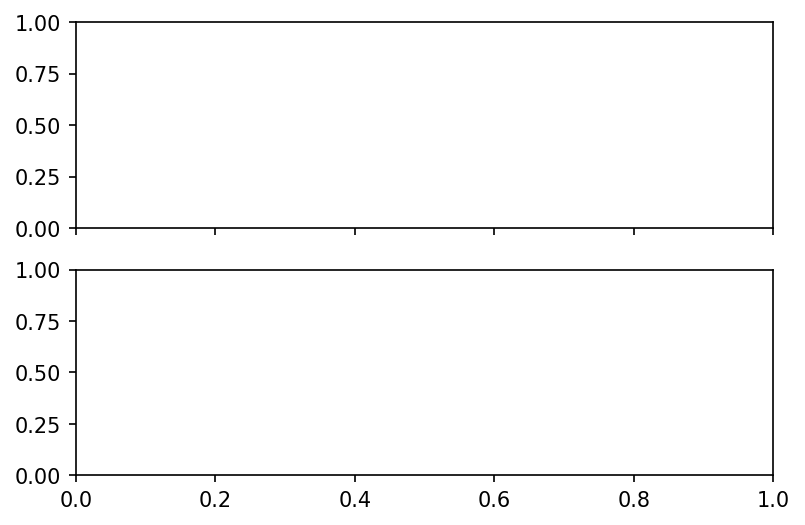

In [8]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(Ns, fro_norms,'b*--', label='Fro')
axs[1].plot(Ns,np.array(ses),'r*-', label='SE')
axs[0].legend()
axs[1].legend()
plt.xlabel('Average N')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(real_Ns, fro_norms,'b*--', label='Fro')
axs[1].plot(real_Ns,np.array(ses),'r*-', label='SE')
axs[0].legend()
axs[1].legend()
plt.xlabel('Average N')
plt.show()